## Simple time series forecasting with `sktime`

`sktime` comes with several forecasting algorithms sharing a common interface.

Forecasters are trained on a single series of data and make predictions within the provided forecast horizon.

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sktime.datasets import load_airline
from sktime.forecasting import *
import numpy as np
import warnings

# Optional - set styling.
import seaborn as sns
sns.set(style="dark", palette="husl")


warnings.simplefilter('ignore', FutureWarning)

For this demo, we will use the famous Box-Jenkins airline data set, which shows the number of international airline passengers per month from 1949-1960.

As well as using the original time series (which is a classic example of a *multiplicative* time series), we will create an *additive* time series by performing a log-transform on the original data, so we may compare forecasters against both types of model.

<IPython.core.display.Javascript object>


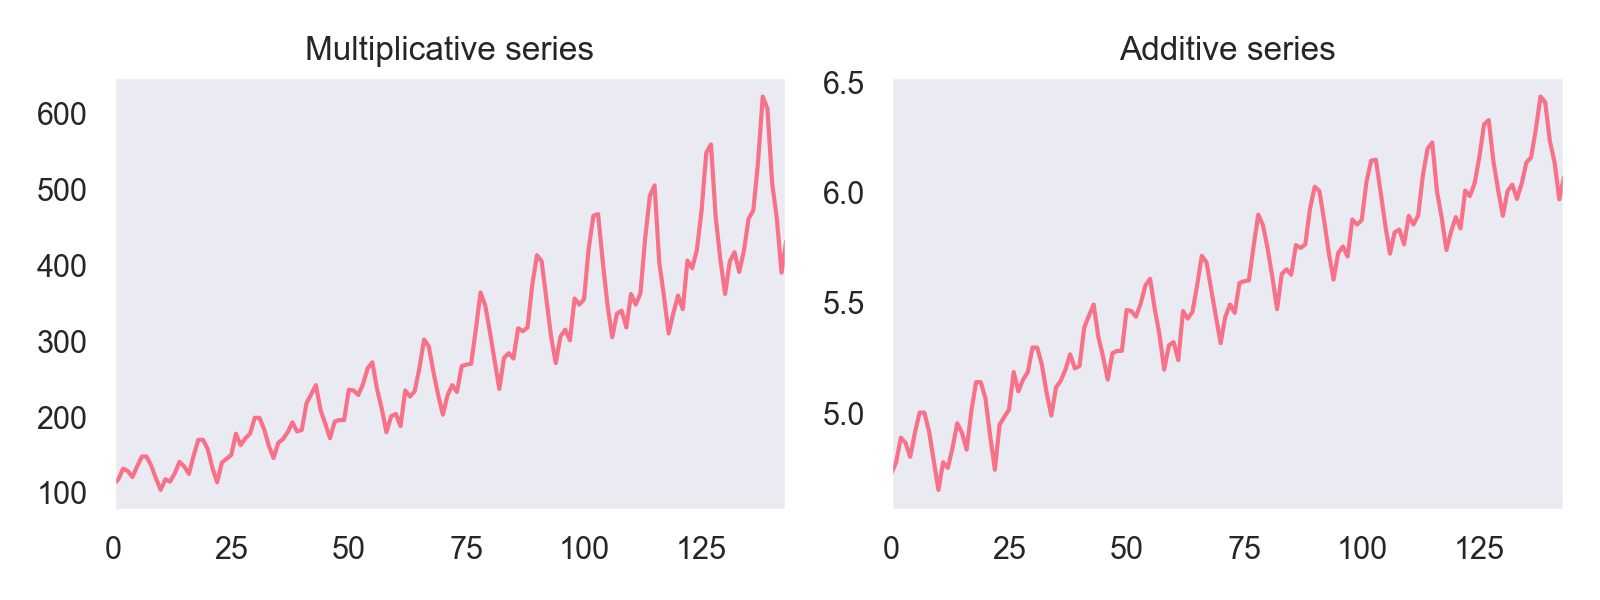

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: Airline, Length: 144, dtype: int64

In [2]:
airline = load_airline()
ln_airline = np.log1p(airline)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
airline.plot(ax=axes[0], title="Multiplicative series")
ln_airline.plot(ax=axes[1], title="Additive series")

fig.tight_layout()

airline

Next we will define a forecasting task. We will try to predict the last four years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 48 points as test data, and use 48-step ahead forecasting horizon to measure performance.

In [3]:
fh_size = 48

In [4]:
def do_forecast(ts, fcstr, fh_size=fh_size, title=None):
    train, test = ts.iloc[:-fh_size], ts.iloc[-fh_size:]
    # Forecast horizons of N steps should be an array of length N, starting at 1.
    fh = np.arange(fh_size) + 1
    
    fcstr.fit(train, fh=fh)
    y_pred = fcstr.predict(fh=fh)
    # If y_pred is omitted, plot() will perform a prediction itself.
    fcstr.plot(y_train=train, y_test=test, y_pred=y_pred, title=title)
    
    return y_pred

Now let's try our forecasters on both datasets. Note that some `sktime` forecasters do not yet have prediction intervals implemented, but this is planned for a future release.

### Simple Exponential Smoothing

SES can provide reasonable results for both the additive and multiplicative time series:

<IPython.core.display.Javascript object>


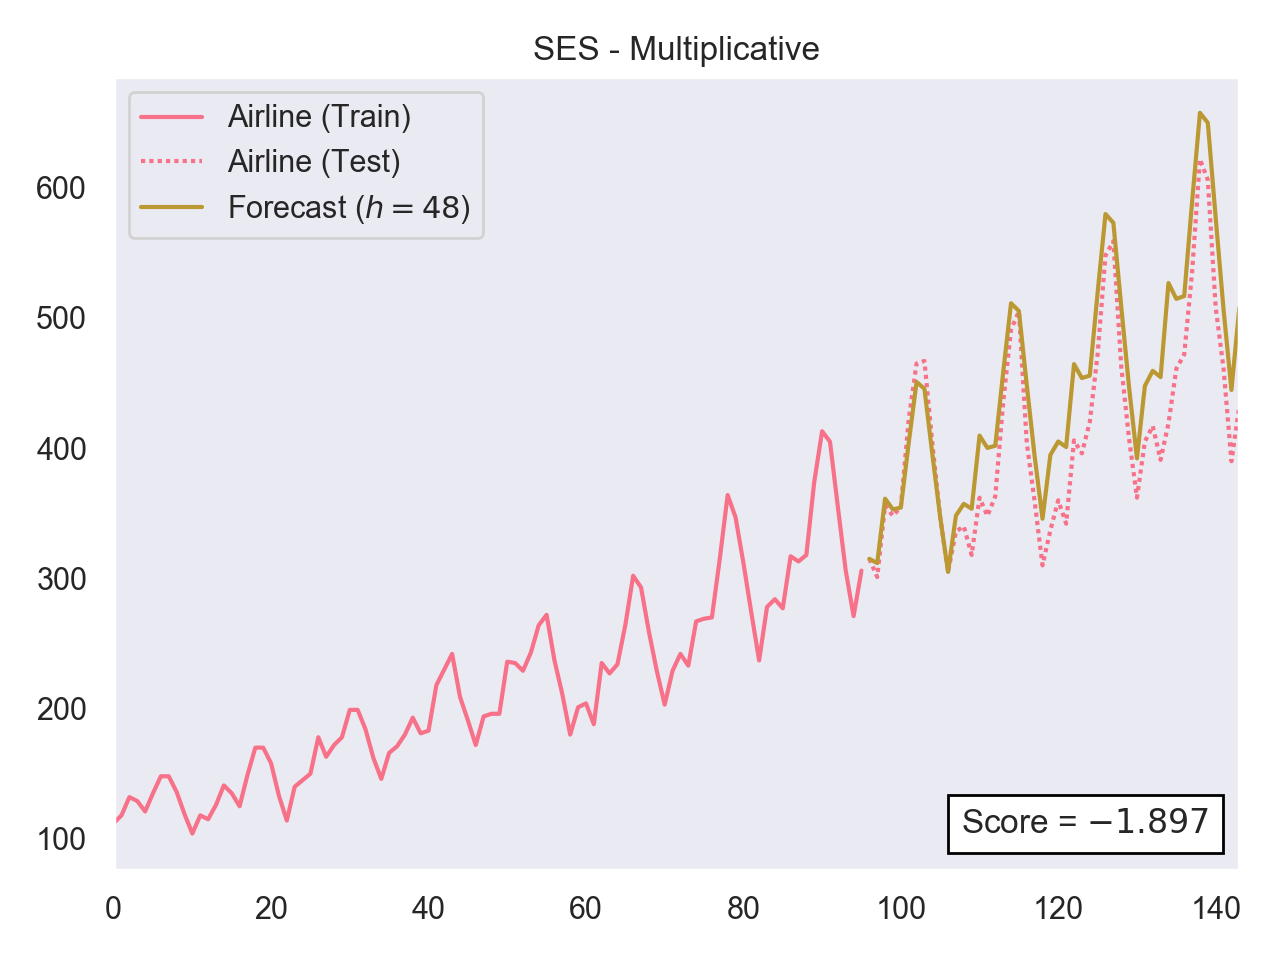

CPU times: user 779 ms, sys: 50.5 ms, total: 829 ms
Wall time: 786 ms


<IPython.core.display.Javascript object>


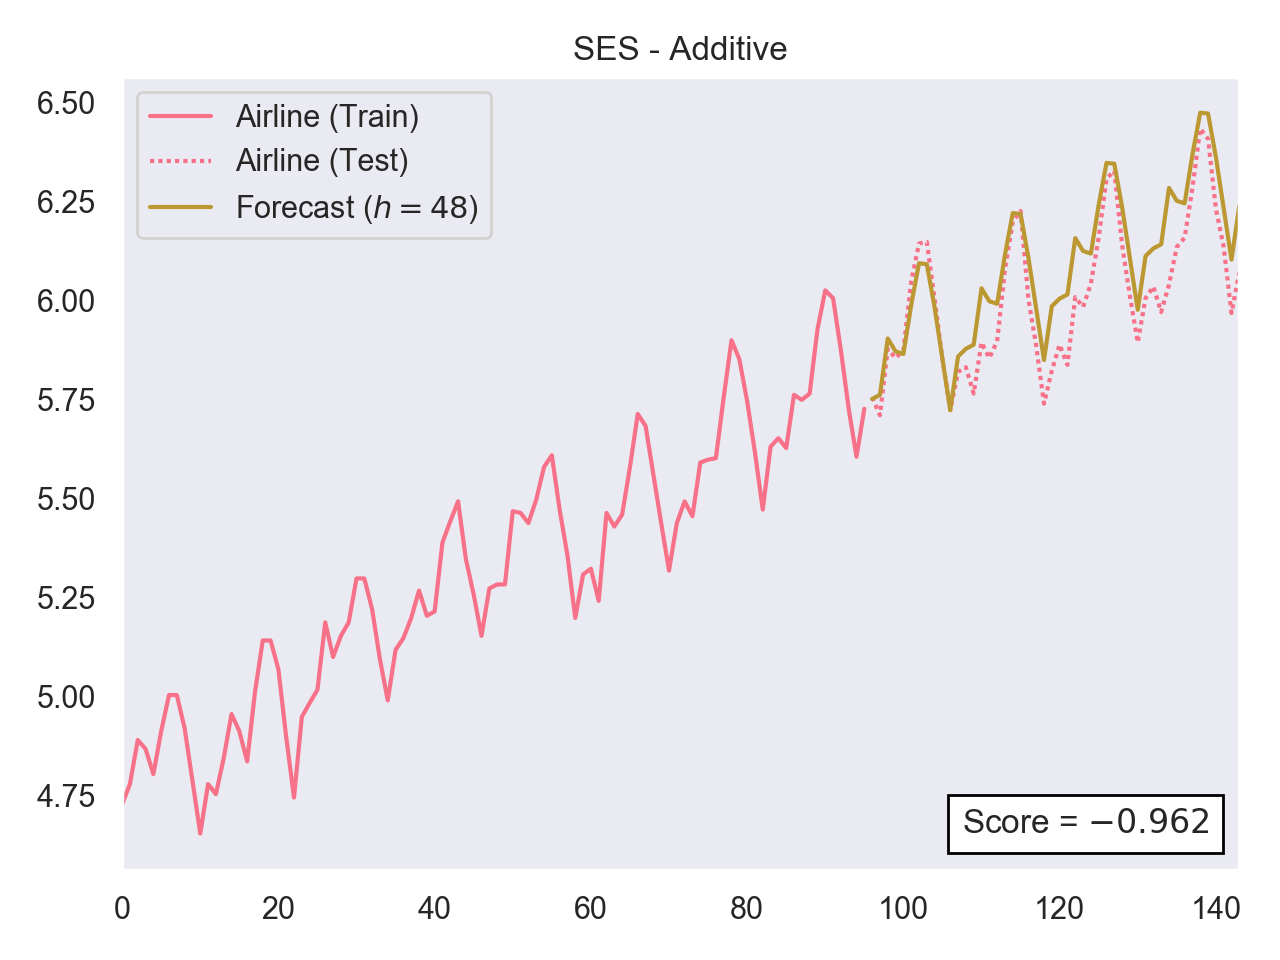

CPU times: user 544 ms, sys: 105 ms, total: 649 ms
Wall time: 450 ms


In [5]:
ses_m = ExpSmoothingForecaster(trend='mul', seasonal='mul', seasonal_periods=12)
%time _ = do_forecast(airline, ses_m, title="SES - Multiplicative")

ses_a = ExpSmoothingForecaster(trend='add', seasonal='add', seasonal_periods=12)
%time _ = do_forecast(ln_airline, ses_a, title="SES - Additive")

### Theta lines

A variant on SES is finding *Theta lines*. This provides slightly better forecasts for the additive series than SES, but performs poorly with the multiplicative series.

<IPython.core.display.Javascript object>


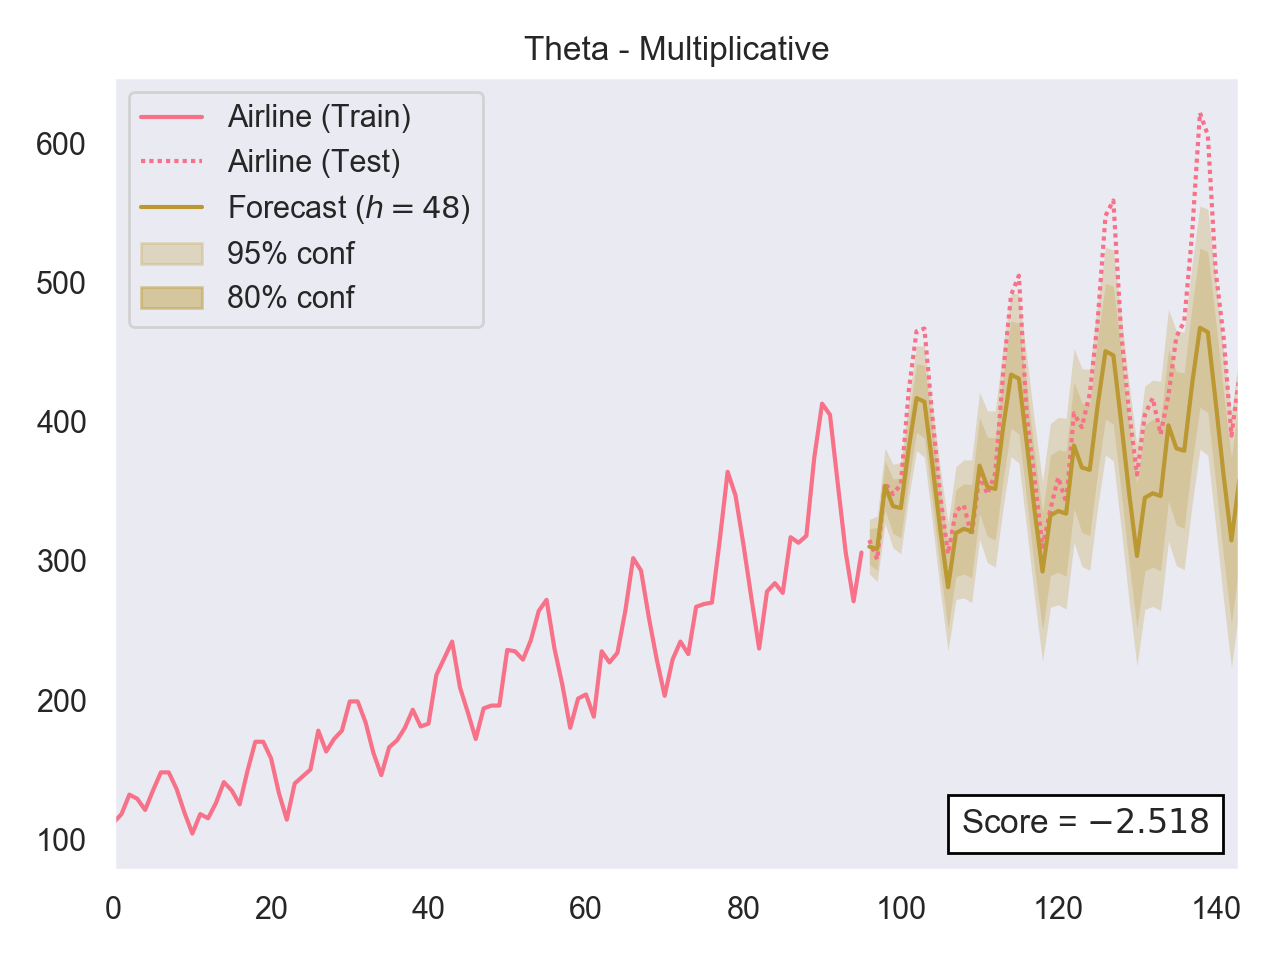

CPU times: user 632 ms, sys: 105 ms, total: 737 ms
Wall time: 551 ms


<IPython.core.display.Javascript object>


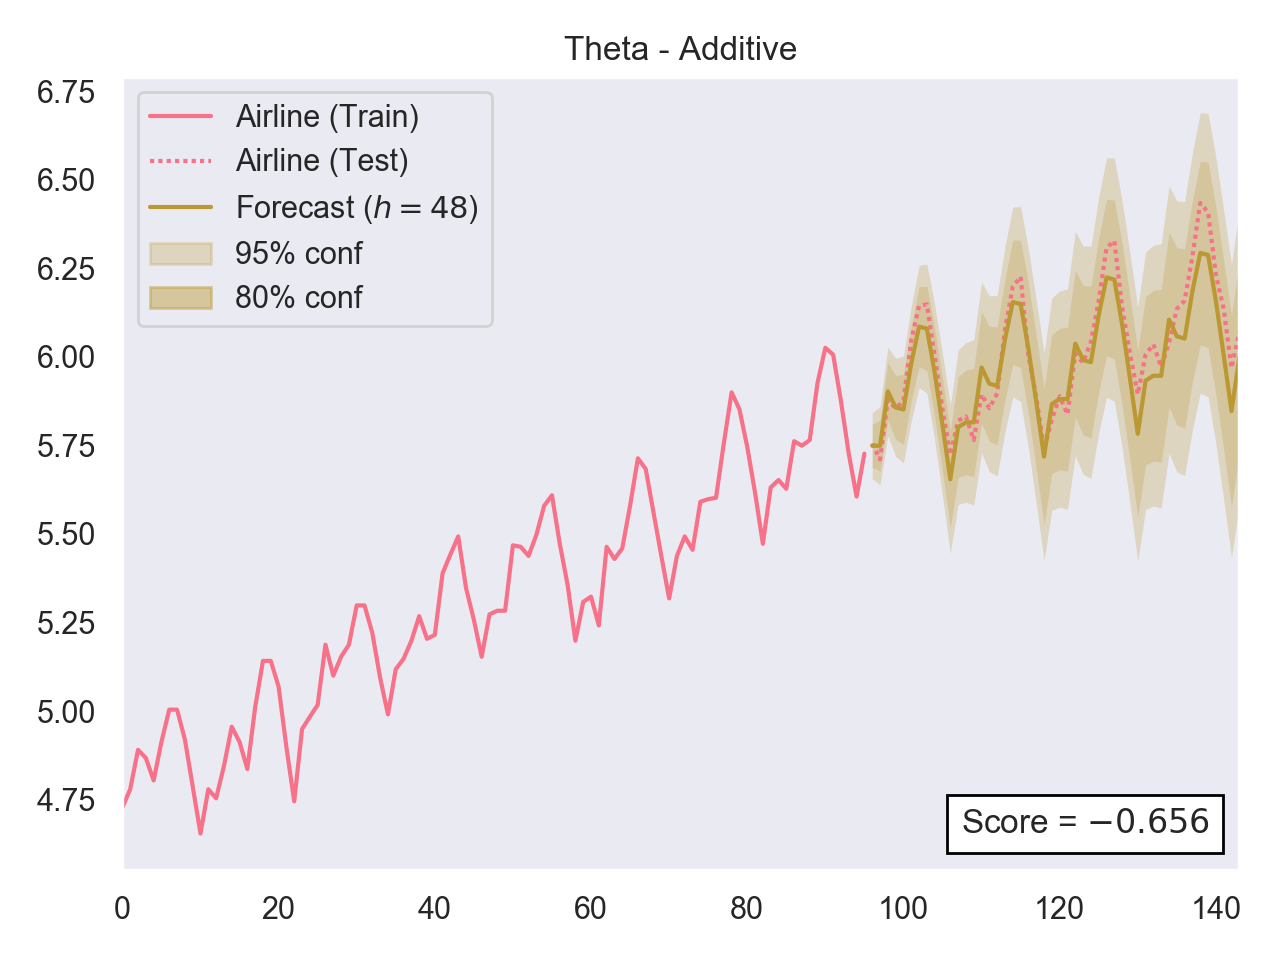

CPU times: user 647 ms, sys: 93.7 ms, total: 741 ms
Wall time: 544 ms


In [6]:
theta_m = ThetaForecaster(seasonal_periods=12)
%time _ = do_forecast(airline, theta_m, title="Theta - Multiplicative")

theta_a = ThetaForecaster(seasonal_periods=12)
%time _ = do_forecast(ln_airline, theta_a, title="Theta - Additive")

### ARIMA

Arima forecasting works well on both series, however it is much slower than the other forecasters:

In [7]:
# arima321_m = ARIMAForecaster(seasonal_order=(3, 2, 1, 12))
# %time _ = do_forecast(airline, arima321_m, title="ARIMA - Multiplicative")

# arima321_a = ARIMAForecaster(seasonal_order=(3, 2, 1, 12))
# %time _ = do_forecast(ln_airline, arima321_a, title="ARIMA - Additive")

### Dummy

Finally, dummy forecasters are also available. They are probably not useful for practical predictions, but may provide a helpful baseline for comparisons. Let's look at the different forecasting strategies for the additive series only:

<IPython.core.display.Javascript object>


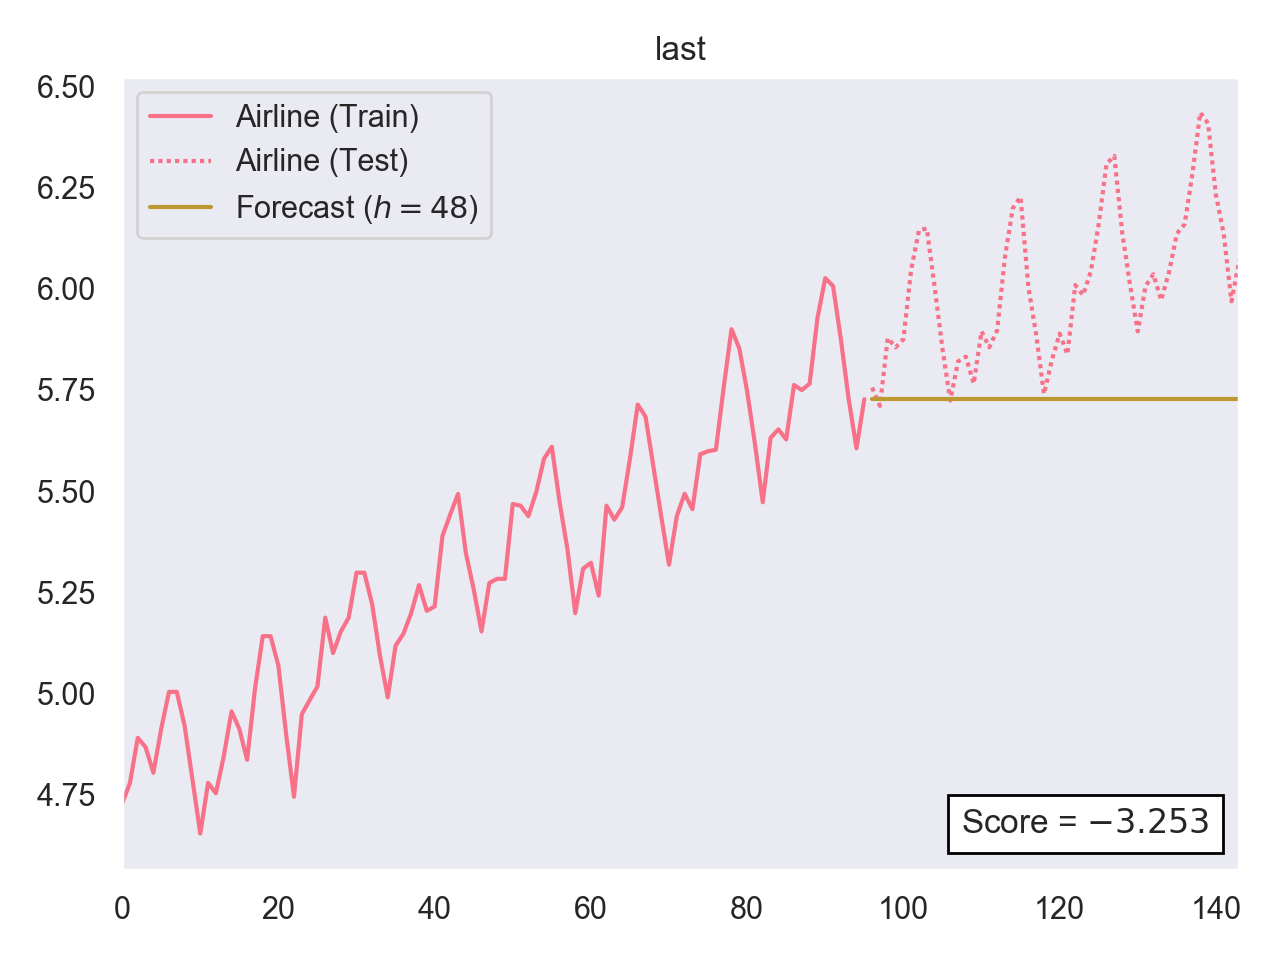

CPU times: user 571 ms, sys: 90.6 ms, total: 662 ms
Wall time: 501 ms


<IPython.core.display.Javascript object>


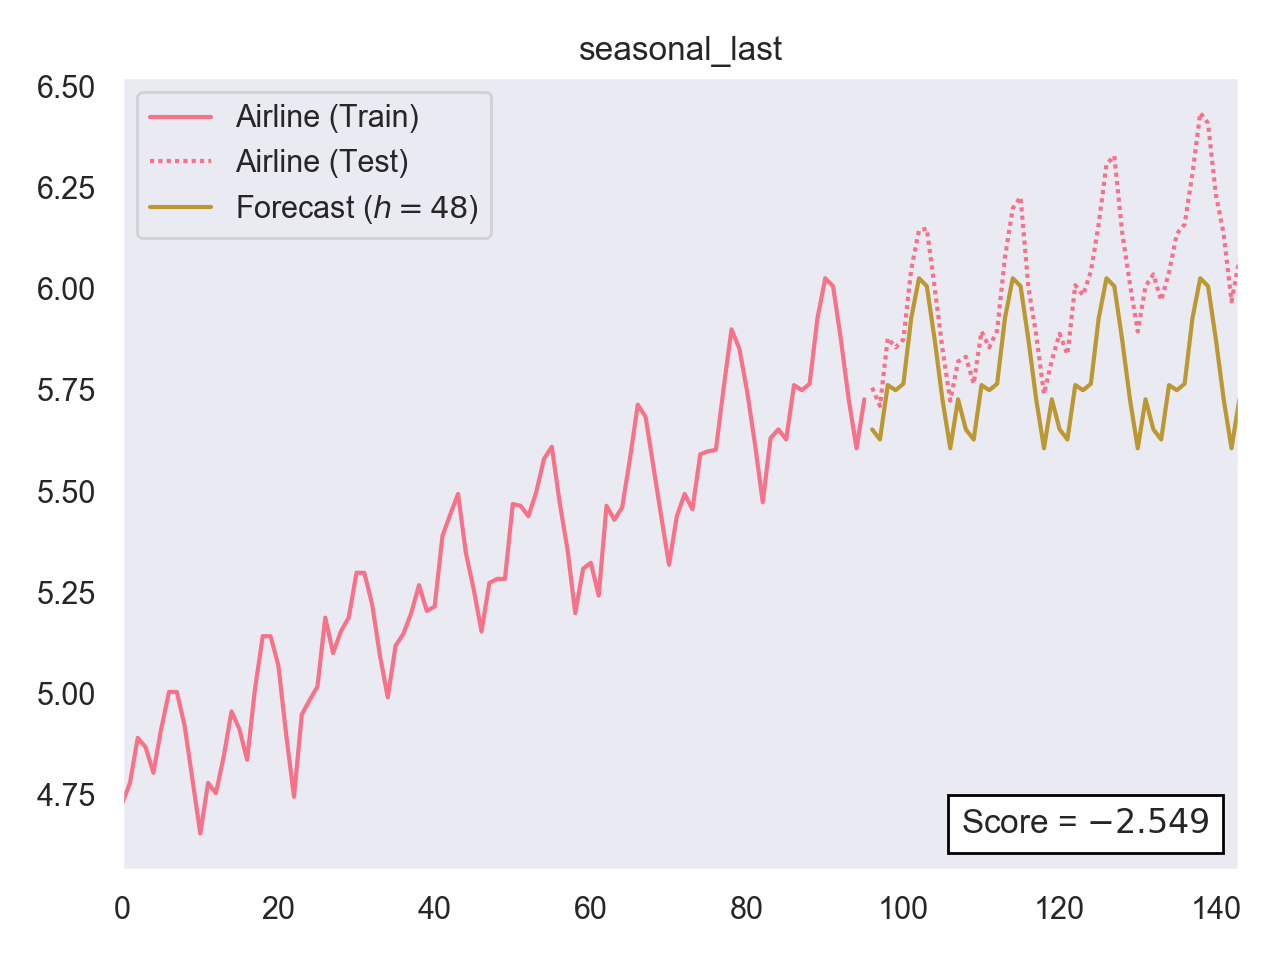

CPU times: user 560 ms, sys: 102 ms, total: 662 ms
Wall time: 460 ms


<IPython.core.display.Javascript object>


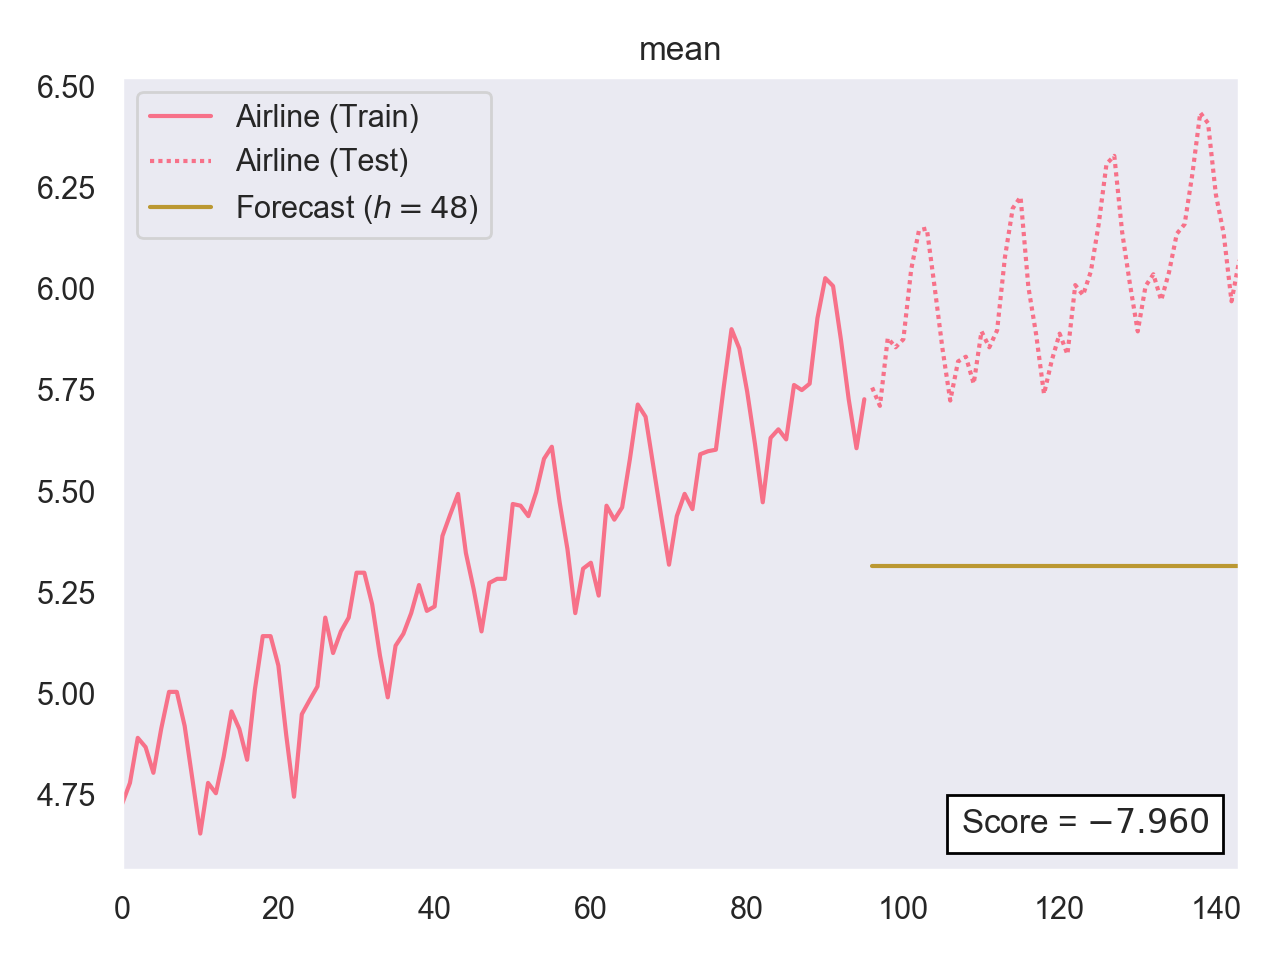

CPU times: user 564 ms, sys: 94.6 ms, total: 658 ms
Wall time: 458 ms


In [8]:
%time _ = do_forecast(ln_airline, DummyForecaster(strategy='last'), title="last")
%time _ = do_forecast(ln_airline, DummyForecaster(strategy='seasonal_last', sp=12), title="seasonal_last")
%time _ = do_forecast(ln_airline, DummyForecaster(strategy='mean'), title="mean")